# User-based recommendations
The section uses hashing and jaccard similarity to recommend books to a given user.

Import packages

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
#import sklearn
import numpy as np
import mmh3
import seaborn

Read cleaned data

In [2]:
book_data = pd.read_csv('../clean_data/books_data_clean.csv')
book_ratings = pd.read_csv('../clean_data/books_rating_clean.csv')

Helper functions

In [3]:
k = 100 # number of minhashes
docs = {} #dictionary mapping document id to document contents

#hashes a list of strings
def listhash(l,seed):
	val = 0
	for e in l:
		val = val ^ mmh3.hash(e, seed)
	return val 

def minhash(shingles_list, seed):
    """
    Input:
        - shingles_list (list of str): set of hashes
        - seed (int): seed for listhash function
    Return: minhash of given shingles
    """
    minhash_value = None
    for aShingle in shingles_list:
        hashcode = listhash([aShingle], seed)
        if minhash_value == None or hashcode < minhash_value:
            minhash_value = hashcode
    return minhash_value

def minhash2(shingles_list, k):
    """
    Input:
        - shingles_list (list of str): set of hashes
        - k (int): seed for listhash function
    Return: sequence of k minhashes
    """
    all_minhash = []
    for i in range(k):
        all_minhash.append(minhash(shingles_list, i))
    return all_minhash

def signature(dict_docs, num_hashes = k):
    """
    Input:
        - dict_docs (dict of str:str): dictionary of {title:document}
        - q (int)
        - num_hashes (int)
    Return: dictionary consisting of document id’s as keys and signatures as values
    """
    dict_signatures = {}
    for key,text in dict_docs.items():
        doc_shingles = [str(item) for item in text]
        minhash_values = minhash2(doc_shingles, num_hashes)
        dict_signatures[key] = minhash_values
        
    return dict_signatures



### Create dictionary of which books each user has read. 

In [4]:
book_ratings1 = book_ratings[book_ratings["score"]==5]
book_ratings1 = book_ratings1[['user_id', 'title']]
users = book_ratings1["user_id"].unique()
list_dict = {}
list_dict_list = []
for user in (users):
    values = list(book_ratings1.query("user_id == @user")["title"])
    list_dict[user]= values
    list_dict_list.append(values)

Create dictionary of signatures for each user

In [5]:
k = 50
dict_signatures = signature(list_dict, num_hashes = k)

### Choose a user and find jaccard similarity between the user and all other users.

In [6]:
# Function to calculate jaccard similarity
def jaccard(name1, name2, signatures_dict):
    """
    Input:
        - name1 (str): name of first user S
        - name2 (str): name of second user T
        - signatures_dict (dict of str:list): dictionary of signatures
    Return: Jaccard similarity between S and T
    """
    signatures_doc1 = np.array(signatures_dict[name1])
    signatures_doc2 = np.array(signatures_dict[name2])
    return len(np.intersect1d(signatures_doc1, signatures_doc2))/len(np.union1d(signatures_doc1, signatures_doc2))

# Function to find similar items using Jaccard similarity
def similar(signatures_dict, jaccard_threshold=0.6):
    """
    Input:
        - signatures_dict (dict of str:list): dictionary of signatures
        - jaccard_threshold (float): lower bound for Jaccard similarity score to consider
            two documents as similar
    Return: dictionary of similar items
    """
    list_keys = list(signatures_dict.keys())
    similar_items = {}
    for i in range (len(list_keys)-1):
        for j in range (i+1, len(list_keys)):
            similarity_score = jaccard(list_keys[i], list_keys[j], signatures_dict)
            if similarity_score >= jaccard_threshold:
                similar_items[(list_keys[i], list_keys[j])] = similarity_score
    return similar_items

# Function to find similar items to user1 using Jaccard similarity
def similar(signatures_dict, user1,user_num):
    """
    Input:
        - signatures_dict (dict of str:list): dictionary of signatures
        - jaccard_threshold (float): lower bound for Jaccard similarity score to consider
            two documents as similar
    Return: dictionary of similar items
    """
    list_keys = list(signatures_dict.keys())
    similar_items = []
    for i in range (len(list_keys)-1):
        if list_keys[i] == user1:
            continue
        similarity_score = jaccard(user1, list_keys[i], signatures_dict)
        similar_items.append([list_keys[i],similarity_score])
    similar_items = pd.DataFrame(similar_items)
    similar_items.columns = ["user_id", "sim"]
    similar_items_sort = similar_items.sort_values(by=['sim'], ascending=False)[:user_num]
    return similar_items_sort

def get_books(user1,similar_items_sort,book_num):
    books = list(book_ratings.query("user_id == @user1")["title"])
    friends = list(similar_items_sort.user_id)

    book_ratings_friends = book_ratings1[book_ratings1["user_id"].isin(friends)]
    book_ratings_friends = book_ratings_friends.query("not title in @books")

    book_ratings_freq = book_ratings_friends.value_counts("title")
    book_ratings_freq = book_ratings_freq[:book_num]
    return book_ratings_freq

### Find popular books within these 20 users which chosen user has not read

Index(['foundation', 'fahrenheit', 'second fou', 'the martia', 'the giver',
       'the hobbit', 'a canticle', 'i robot', 'the lord o', 'lord of th'],
      dtype='object')

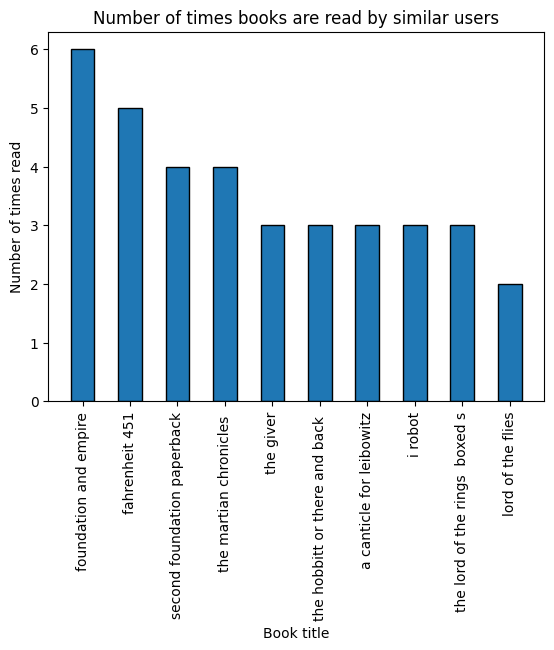

In [21]:
#import operator
user = "A126KX6FVI4T66"
user_num = 20
book_num = 10

text_length = 30


similar_items_sort = similar(dict_signatures,user,user_num)

books = get_books(user,similar_items_sort,book_num)
books.index = [i[:text_length] for i in books.index]


fig, ax = plt.subplots()

plt.xticks(rotation=90)

ax.bar(books.index,books.values, edgecolor = "black", width=0.5)
ax.set_title("Number of times books are read by similar users")
ax.set_ylabel("Number of times read")
ax.set_xlabel("Book title")

plt.savefig("book_read.png", bbox_inches='tight')

plt.show()


In [8]:
title1 = "foundation and empire"
title2 = "second foundation paperback"

t1 = book_data.query("title == @title1")["description"]
t2 = book_data.query("title == @title2")["description"]

display(t1)
display(t2)

4837    This book presents the ontological and logical...
Name: description, dtype: object

16108    When the First Foundation was conquered by a f...
Name: description, dtype: object

## Fequent sets

In [9]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

In [10]:
list_dict

#list_dict2 = [list(idx.values()) for idx in list_dict ]

list_dict_list
#list_dict_list = [str(item) for item in list_dict_list]
string_list_of_lists = [[str(item) for item in inner_list] for inner_list in list_dict_list]
#string_list_of_lists

In [11]:
te = TransactionEncoder()
te_ary = te.fit(string_list_of_lists).transform(string_list_of_lists)
df_one_hot = pd.DataFrame(te_ary, columns=te.columns_)
df_one_hot

,the sense of wonder,1 is one,10 days to faster reading,10 secrets for success and inner peace,10 stupid things couples do to mess up their relationships,100 amazing facts about the negro with complete proof a short cut to the world history of the negro,100 best album covers,100 flowers and how they got their names,100 great breads,100 onenight reads a book lovers guide,...,zon,zondervan niv matthew henry commentary,zondervan niv study bible,zondervan niv study bible compact,zondervan niv wide margin bible,zorba the greek,zoroastrians their religious beliefs and practices,zorro a novel,zoya,zuleika dobson
0,False,False,False,True,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3398,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3399,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3400,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3401,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [12]:
frq_items = apriori(df_one_hot, min_support = 0.0025, use_colnames = True)
frq_items['length'] = frq_items['itemsets'].apply(lambda x: len(x))
frq_items_sets = frq_items.query('length >= 3')

In [13]:
val = 3
frq_items_sets.query('length >= 4')["itemsets"].values[val]
frq_items_sets


,support,itemsets,length
2769,0.004996,"(1984, brave new world, animal farm )",3
2770,0.003820,"(1984, fahrenheit 451, animal farm )",3
2771,0.002939,"(1984, animal farm , the great gatsby)",3
2772,0.003820,"(1984, brave new world, fahrenheit 451)",3
2773,0.002645,"(1984, brave new world, the grapes of wrath )",3
...,...,...,...
2860,0.003820,"(the no 1 ladies detective agency, the kalahar...",4
2861,0.002645,"(the no 1 ladies detective agency, morality fo...",4
2862,0.003526,"(the two towers, the fellowship of the ring, t...",4
2863,0.002939,"(the no 1 ladies detective agency, the kalahar...",4
